In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

In [7]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Increase font size to match Beamer template
plt.rcParams["font.size"] = 16
# Make background transparent
plt.rcParams["figure.facecolor"] = "none"
# use font size Roboto Condensed
plt.rcParams["font.family"] = "sans-serif"

In [8]:
if torch.cuda.is_available():
     torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [12]:
context_size = 5

hidden_size = 128  # Number of neurons in each hidden layer of base model and number of ouput of adaptive network
num_output_adaptive = hidden_size
num_input_setEncoderAr = hidden_size

num_output_setEncoderContext = 128

num_output_setEncoderAr = 128

input_size_adaptation_network = num_output_setEncoderContext + num_output_setEncoderAr



In [13]:
# Define a simple MLP model for regression with 5 hidden layers
num_layers_MLPRegressor = 4         # except the last layer - to be used for number of gamma and beta parameters

class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

In [14]:
# Define a simple MLP model for regression with 5 hidden layers
class adaptiveMLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(adaptiveMLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression

    def forward(self, x_context, y_context, x_target, adaptiveNetwork):
        globalSetEncoderContext = adaptiveNetwork.globalSetEncoderContext
        totalAdaptiveNetworkList = adaptiveNetwork.totalAdaptiveNetworkList

        embeddingContext = globalSetEncoderContext(x_context, y_context)
        embeddingContext = embeddingContext.mean(dim=0).unsqueeze(1)
        embeddingContext = embeddingContext.repeat(1, x_target.shape[0])
        embeddingContext = embeddingContext.T
        gamma_beta_dict0 = totalAdaptiveNetworkList[0](embeddingContext, x_target)

        out = self.fc1(x_target)
        out = self.relu(out)
        out = out * gamma_beta_dict0['gamma'] + gamma_beta_dict0['beta']

        # totalAdaptiveNetworkList[1](embeddingContext, out) -> gamma1, beta1
        gamma_beta_dict1 = totalAdaptiveNetworkList[1](embeddingContext, out)


        out = self.fc2(out)
        out = self.relu(out)
        out = out * gamma_beta_dict1['gamma'] + gamma_beta_dict1['beta']

        # totalAdaptiveNetworkList[2](embeddingContext, out) -> gamma2, beta2
        gamma_beta_dict2 = totalAdaptiveNetworkList[2](embeddingContext, out)

        out = self.fc3(out)
        out = self.relu(out)
        out = out * gamma_beta_dict2['gamma'] + gamma_beta_dict2['beta']

        # totalAdaptiveNetworkList[3](embeddingContext, out) -> gamma3, beta3
        gamma_beta_dict3 = totalAdaptiveNetworkList[3](embeddingContext, out)

        out = self.fc4(out)
        out = self.relu(out)
        out = out * gamma_beta_dict3['gamma'] + gamma_beta_dict3['beta']

        out = self.fc5(out)
        
        return out

In [15]:
class totalAdaptationNetwork(nn.Module):
    def __init__(self, inpute_size_Ar, hidden_size):
        super(totalAdaptationNetwork, self).__init__()
        self.setEncoderArNetwork = setEncoderAr(inpute_size_Ar, hidden_size)
        self.gammaAdaptationNetwork = gammaAdaptationNetwork(input_size_adaptation_network, hidden_size)
        self.betaAdaptationNetwork = betaAdaptationNetwork(input_size_adaptation_network, hidden_size)

    def forward(self, embeddingContext, x_target_activations):
        embeddingAr = self.setEncoderArNetwork(x_target_activations)
        gamma = self.gammaAdaptationNetwork(embeddingContext, embeddingAr)
        beta = self.betaAdaptationNetwork(embeddingContext, embeddingAr)
        return {'gamma': gamma, 'beta': beta}       

In [16]:
class allAdaptationNetworks(nn.Module):
    def __init__(self, hidden_size):
        super(allAdaptationNetworks, self).__init__()
        self.globalSetEncoderContext = setEncoderContext(hidden_size)
        self.encoderArInputSizes = [1, 128, 128, 128]
        self.totalAdaptiveNetworkList = torch.nn.ModuleList()
        for size in self.encoderArInputSizes:
            self.totalAdaptiveNetworkList.append(totalAdaptationNetwork(size, hidden_size))   # List of adaptive networks (which include ArSetEncoder, gammaAdaptaionNetwork, betaAdaptationNetwork for all)

In [17]:
class setEncoderContext(nn.Module):
    def __init__(self, hidden_size):
        super(setEncoderContext, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)            # input_size = 2 (for x and y point)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_setEncoderContext)  # Output layer with one node for regression
        
    def forward(self, x_context, y_context):     # x_y corresponds to a single point
        x_y = torch.cat((x_context, y_context), 1)
        # print(x_y.shape)
        out = self.fc1(x_y)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out    

In [18]:
### change
class setEncoderAr(nn.Module):
    def __init__(self, input_size_Ar, hidden_size):
        super(setEncoderAr, self).__init__()
        ###
        self.fc1 = nn.Linear(input_size_Ar, hidden_size)            # input_size = 2 (for x and y point)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_setEncoderAr)  # Output layer with one node for regression
        
    def forward(self, target_activations):     # x_y corresponds to a single point
        out = self.fc1(target_activations)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out    

In [19]:
# setEncoderContextNetwork = setEncoderContext(hidden_size)

In [20]:
# setEncoderArNetwork = setEncoderContext(hidden_size)

In [21]:
# def getEmbeddingsContext(X, y):
#     embeding = torch.concat((X, y), dim=0).flatten()
#     # print(embeding.shape)
#     # assert embeding.shape[0] == 40
#     return embeding


# def getEmbeddingsContext(X, y):
#     # print("Inside getEmbeddingsContext: ", X.shape, y.shape)
#     X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), dim=1)
#     embeding = setEncoderContextNetwork(X_y)
#     embeding = embeding.mean(dim=0)            # Average over all the points in the set, size = (1, num_output_setEncoderContext)
#     # embeding = embeding.squeeze()           # size = (num_output_setEncoderContext)
#     # embeding = embeding.unsqueeze(1)        # size = (num_output_setEncoderContext, 1)
#     # print(embeding.shape)
#     # assert embeding.shape[0] == 40
#     return embeding

In [22]:
# def getEmbeddingsAr(w):
#     embeding = setEncoderArNetwork(w)
#     return embeding

In [23]:
class gammaAdaptationNetwork(nn.Module):
    def __init__(self, input_size_adaptation_network, hidden_size):
        super(gammaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size_adaptation_network, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_adaptive)  # Output layer with one node for regression
        
    def forward(self, embeddingsContext, embeddingsAr):
        # print(embeddingsContext.shape, embeddingsAr.shape)
        embeddings = torch.cat((embeddingsContext, embeddingsAr), dim=1)
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out

In [24]:
class betaAdaptationNetwork(nn.Module):
    def __init__(self, input_size_adaptation_network, hidden_size):
        super(betaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size_adaptation_network, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_adaptive)  # Output layer with one node for regression
        
    def forward(self, embeddingsContext, embeddingsAr):
        embeddings = torch.cat((embeddingsContext, embeddingsAr), dim=1)
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out

In [25]:
# class adaptationNetwork(nn.Module):
#     def __init__(self, input_size_adaptation_network, hidden_size):
#         super(adaptationNetwork, self).__init__()

#         self.gammaNetProcessors, self.betaNetProcessors = torch.nn.ModuleList(), torch.nn.ModuleList()

#         for i in range(num_layers_MLPRegressor):
#             self.gammaNetProcessors.append(gammaAdaptationNetwork(input_size_adaptation_network, hidden_size))
#             self.betaNetProcessors.append(betaAdaptationNetwork(input_size_adaptation_network, hidden_size))
        
#     def forward(self, X, y, w):
#         gamma_beta_lst = []
#         embeddingsContext = getEmbeddingsContext(X, y)
#         for i in range(num_layers_MLPRegressor):
#             ### Define which w
#             embeddingsAr = getEmbeddingsAr(w[i])
#             embeddings = torch.cat((embeddingsContext, embeddingsAr), dim=0).flatten()

#             gamma_beta_dict = {'gamma': self.gammaNetProcessors[i](embeddings), 'beta': self.betaNetProcessors[i](embeddings)}
#             gamma_beta_lst.append(gamma_beta_dict)
#         return gamma_beta_lst

In [26]:
# def get_sine(sine_params, X, i):
#     torch.manual_seed(0)
#     return sine_params[i][0] * torch.sin(sine_params[i][1] * X + sine_params[i][2]) + sine_params[i][3] + torch.randn(X.shape) * 0.1

def get_sine(sine_params, X, i):
    torch.manual_seed(0)
    noisy_sine = sine_params[i][0] * torch.sin(X + sine_params[i][1]) + torch.randn(X.shape) * 0.1
    true_sine = sine_params[i][0] * torch.sin(X + sine_params[i][1])
    return noisy_sine, true_sine

In [27]:
# Dataset creation

# sine_params = torch.tensor(sine_params)
torch.manual_seed(0)
num_datasets = 101
num_points_per_dataset = 500
true_sines = []
A = torch.distributions.Uniform(0.5, 5).sample((num_datasets,))
phi = torch.distributions.Uniform(0, 2 * np.pi).sample((num_datasets,))
sine_params = torch.stack((A, phi), dim=1)

# Generate synthetic data for regression
torch.manual_seed(0)
dataset = [None] * num_datasets  # List of datasets for each function

for i in range(num_datasets):
    # upper_bound = 2 * torch.pi / sine_params[i][1]
    upper_bound = 2 * torch.pi
    X = torch.linspace(0, upper_bound, num_points_per_dataset)
    y, true_sine = get_sine(sine_params, X, i)  # Sine function with noise
    X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), 1)
    dataset[i] = X_y
    true_sines.append(true_sine)

In [28]:
# dataset[0].size()[0]
index = [i for i in range(0, 500, 10)]
index

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490]

/tmp/ipykernel_1384648/3681113924.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.6)


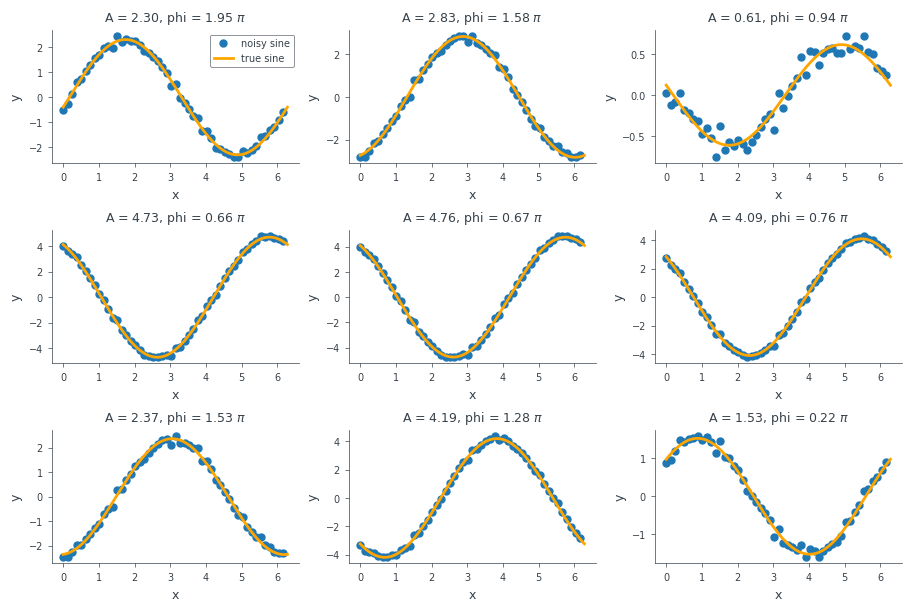

In [29]:
# plot 15 sine functions and adjust margins
plt.figure(figsize=(9, 6))
plt.subplots_adjust(hspace=0.6)

for i in range(9):
    plt.subplot(3, 3, i+1)
    if i ==0:
        plt.plot(dataset[i][index, 0].cpu(), dataset[i][index, 1].cpu(), marker='o', color='tab:blue', linestyle='none', markersize=5, label='noisy sine')
        plt.plot(dataset[i][:, 0].cpu(), true_sines[i].cpu(), color='orange', linewidth=2, label='true sine')
        plt.legend()
    else:
        plt.plot(dataset[i][index, 0].cpu(), dataset[i][index, 1].cpu(), marker='o', color='tab:blue', linestyle='none', markersize=5, label='noisy sine')
        plt.plot(dataset[i][:, 0].cpu(), true_sines[i].cpu(), color='orange', linewidth=2, label='true sine')
    # plt.title('Sine function {}'.format(i))
    plt.title(f'A = {sine_params[i][0]:.2f}, phi = {sine_params[i][1]/3.14:.2f} $\pi$')
    plt.xlabel('x')
    # plt.label('y')
    
    plt.xlabel('x')
    plt.ylabel('y')

# save the tue plot in pdf format
plt.savefig('sine_functions.pdf', bbox_inches='tight', transparent=True)

In [30]:
print('len(dataset): ', len(dataset))
print('len(dataset[0]): ', len(dataset[0]))
print('dataset[0].type(): ', dataset[0].type())

len(dataset):  101
len(dataset[0]):  500
dataset[0].type():  torch.cuda.FloatTensor


In [31]:
# Dataset creation for meta learning

newdataset = []
num_datapoints_per_small_task = 50      # this is the number of datapoints we will use for each iteration of meta learning

for i in range(0, len(dataset)):
    torch.manual_seed(i)
    num_elements = dataset[i].shape[0]
    permuted_indices = torch.randperm(num_elements) # Generate a random permutation of indices
    dataset[i] = dataset[i][permuted_indices]

    # i=0 case will be used for training of main network, therefore, kept intact. Others will be used for meta learning and testing, therefore devided in chunks of 50
    if i>=1:
        for j in range(int(dataset[i].shape[0] / num_datapoints_per_small_task)):
            newdataset.append(dataset[i][j*num_datapoints_per_small_task:(j+1)*num_datapoints_per_small_task,:])

In [ ]:
print('len(newdataset): ', len(newdataset))
print('len(newdataset[0]): ', len(newdataset[0]))
# print('newdataset[0]: ', newdataset[0])
# print('newdataset[1]: ', newdataset[1])

In [ ]:
# train and test split for meta learning
random.seed(0)
train_dataset = newdataset[:int(len(newdataset)*0.8)]
random.shuffle(train_dataset)       # Shuffle the dataset in-place
test_dataset = newdataset[int(len(newdataset)*0.8):]
random.shuffle(test_dataset)

In [ ]:
# Training base model

# Hyperparameters
input_size = 1  # One input feature
learning_rate_base_model = 0.01
num_epochs_base_model = 200
split_ratio_base_model = 0.8    # for training and validation of base model

# Initialize the MLP regression baseModel
baseModel = MLPRegressor(input_size, hidden_size)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(baseModel.parameters(), lr=learning_rate_base_model)

# Training loop
for epoch in range(num_epochs_base_model):
    # Forward pass
    outputs = baseModel(dataset[0][:int(num_points_per_dataset*split_ratio_base_model), 0].unsqueeze(1))
    loss = criterion(outputs, dataset[0][:int(num_points_per_dataset*split_ratio_base_model), 1].unsqueeze(1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_base_model}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    # predicted = baseModel(X)
    predicted = baseModel(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1))

# print("Predicted values:")
# print(predicted)

# Save the trained baseModel
torch.save(baseModel.state_dict(), 'checkpoints/baseModel.ckpt')
print('MLP regression baseModel with 5 hidden layers trained and saved!')

In [ ]:
# find the number of parameters
print('Number of parameters in the model: ', sum([param.nelement() for param in baseModel.parameters()]))

In [ ]:
# plot x and y
plt.plot(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1).cpu(), dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 1].unsqueeze(1).cpu(), 'ro', label='Original data')
plt.plot(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1).cpu(), predicted.cpu(), 'bo', label='Fitted line')
plt.legend()
plt.show()

In [ ]:
# def load_base_models_params(adaptiveMLPRegModel):
#     dicts = torch.load('checkpoints/baseModel.ckpt')
#     adaptiveMLPRegModel.fc1.weight = nn.Parameter(dicts['fc1.weight'])
#     adaptiveMLPRegModel.fc1.bias = nn.Parameter(dicts['fc1.bias'])
#     adaptiveMLPRegModel.fc2.weight = nn.Parameter(dicts['fc2.weight'])
#     adaptiveMLPRegModel.fc2.bias = nn.Parameter(dicts['fc2.bias'])
#     adaptiveMLPRegModel.fc3.weight = nn.Parameter(dicts['fc3.weight'])
#     adaptiveMLPRegModel.fc3.bias = nn.Parameter(dicts['fc3.bias'])
#     adaptiveMLPRegModel.fc4.weight = nn.Parameter(dicts['fc4.weight'])
#     adaptiveMLPRegModel.fc4.bias = nn.Parameter(dicts['fc4.bias'])
#     adaptiveMLPRegModel.fc5.weight = nn.Parameter(dicts['fc5.weight'])
#     adaptiveMLPRegModel.fc5.bias = nn.Parameter(dicts['fc5.bias'])
#     return adaptiveMLPRegModel


In [ ]:
# Training meta model

# Hyperparameters
learning_rate_adaptive_network = 0.001
num_epochs_adaptive_network = 200

# Initialize the MLP regression baseModel
adaptiveMLPRegModel = adaptiveMLPRegressor(input_size, hidden_size)

# load the trained baseModel
adaptiveMLPRegModel.load_state_dict(torch.load('checkpoints/baseModel.ckpt'))
# adaptiveMLPRegModel = load_base_models_params(adaptiveMLPRegModel)
adaptiveNetwork = allAdaptationNetworks(hidden_size)

# freez the weights of the baseModel
for param in adaptiveMLPRegModel.parameters():
    param.requires_grad = False

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(adaptiveNetwork.parameters(), lr=learning_rate_adaptive_network)

train_loss_lst = []
test_loss_lst = []

# Training loop
for epoch in range(num_epochs_adaptive_network):
    loss_sum = 0
    for training_task in train_dataset:
        context = training_task[:context_size]
        target_x = training_task[context_size:, 0].unsqueeze(1)
        target_y = training_task[context_size:, 1].unsqueeze(1)

        ### define w
        
        # gamma_beta_lst = adaptiveNetwork.forward(context[:, 0], context[:, 1], w)
        x_context = context[:, 0].unsqueeze(1)
        y_context = context[:, 1].unsqueeze(1)

        predictions = adaptiveMLPRegModel(x_context, y_context, target_x, adaptiveNetwork)
        loss = criterion(predictions, target_y)
        loss_sum += loss.item()
        # print(f'Epoch [{epoch+1}/{num_epochs_adaptive_network}], Loss: {loss.item():.4f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 1 == 0:
        train_loss_lst.append(loss_sum/len(train_dataset))
        print(f'Epoch [{epoch+1}/{num_epochs_adaptive_network}], Train Loss: {loss_sum/len(train_dataset)}')

        # Make predictions
        with torch.no_grad():
            loss_sum_test = 0
            for test_task in test_dataset:
                context_test = test_task[:context_size]
                target_x_test = test_task[context_size:, 0].unsqueeze(1)
                target_y_test = test_task[context_size:, 1].unsqueeze(1)
                # gamma_beta_dict = adaptiveNetwork.forward(context_test[:, 0], context_test[:, 1])
                # predictions = adaptiveMLPRegModel(target_x, gamma_beta_dict)
                x_context_test = context_test[:, 0].unsqueeze(1)
                y_context_test = context_test[:, 1].unsqueeze(1)
                predictions = adaptiveMLPRegModel(x_context_test, y_context_test, target_x_test, adaptiveNetwork)
                loss = criterion(predictions, target_y_test)
                loss_sum_test += loss.item()
            test_loss_lst.append(loss_sum_test/len(test_dataset))
        print(f'Epoch [{epoch+1}/{num_epochs_adaptive_network}], Test Loss: {loss_sum_test/len(test_dataset)}')
    
    if (epoch + 1) % 100 == 0:
        torch.save(adaptiveMLPRegModel.state_dict(), f'checkpoints/adaptiveNetwork_epoch_{epoch+1}.ckpt')

# print("Predicted values:")
# print(predicted)

# Save the trained adaptiveMLPRegModel
torch.save(adaptiveMLPRegModel.state_dict(), f'checkpoints/adaptiveNetwork_epoch_{num_epochs_adaptive_network+1}.ckpt')
print('adaptiveMLPRegModel trained and saved!')

In [ ]:
# adaptiveNetwork
torch.save(adaptiveNetwork.state_dict(), f'checkpoints/adaptiveNetwork_actual_epoch_{epoch+1}.ckpt')

In [ ]:
# plot train and test loss

plt.plot(train_loss_lst, label='train loss')
plt.plot(test_loss_lst, label='test loss')
plt.xlabel('Num Epochs')
plt.ylabel('MSE Loss')
plt.title('Train and Test Loss')
# limit y axis
# plt.ylim(0, 8)
plt.legend()
plt.show()

In [ ]:
# print to txt file
print("Train loss:", train_loss_lst, file=open("losses.txt", "a"))
print("Test loss:", test_loss_lst, file=open("losses.txt", "a"))

In [ ]:
predictions_y = []
input_x = []
value_y = []
# Make predictions
with torch.no_grad():
    for test_task in test_dataset:
        context_test = test_task[:context_size]
        target_x_test = test_task[context_size:, 0].unsqueeze(1)
        target_y_test = test_task[context_size:, 1].unsqueeze(1)
        # gamma_beta_dict = adaptiveNetwork.forward(context_test[:, 0], context_test[:, 1])
        # predictions = adaptiveMLPRegModel(target_x, gamma_beta_dict)
        x_context_test = context_test[:, 0].unsqueeze(1)
        y_context_test = context_test[:, 1].unsqueeze(1)
        predictions = adaptiveMLPRegModel(x_context_test, y_context_test, target_x_test, adaptiveNetwork)
        # context = test_task[:context_size]
        # target_x = test_task[context_size:, 0].unsqueeze(1)
        # target_y = test_task[context_size:, 1].unsqueeze(1)
        # gamma_beta_dict = adaptiveNetwork.forward(context[:, 0], context[:, 1])
        input_x.append(target_x_test)
        value_y.append(target_y_test)
        # predictions = adaptiveMLPRegModel(target_x, gamma_beta_dict)
        predictions_y.append(predictions)

In [ ]:
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.7)
# plt.subplots_adjust(hspace=0.5)

for i in range(8):
    plt.subplot(4,2, i+1)
    plt.scatter(input_x[i*10].cpu(), value_y[i*10].cpu(), marker='o', label='Ground Truth')
    plt.scatter(input_x[i*10].cpu(), predictions_y[i*10].cpu(), marker='x', label='Predictions')
    plt.xlabel('x')
    plt.ylabel('Prediction')
    plt.title('Function $y = A*sin(x + phi)$'.format(i))
    plt.legend()

### Checking base model's performance

In [ ]:
# Training base model

# Hyperparameters
input_size = 1  # One input feature
learning_rate_base_model = 0.01
num_epochs_base_model = 200
split_ratio_base_model = 0.8    # for training and validation of base model

# Initialize the MLP regression baseModel
baseModel = MLPRegressor(input_size, hidden_size)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(baseModel.parameters(), lr=learning_rate_base_model)

# Training loop
for epoch in range(num_epochs_base_model):
    # Forward pass
    outputs = baseModel(dataset[0][:int(num_points_per_dataset*split_ratio_base_model), 0].unsqueeze(1))
    loss = criterion(outputs, dataset[0][:int(num_points_per_dataset*split_ratio_base_model), 1].unsqueeze(1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_base_model}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    # predicted = baseModel(X)
    predicted = baseModel(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1))

# print("Predicted values:")
# print(predicted)

# Save the trained baseModel
torch.save(baseModel.state_dict(), 'checkpoints/baseModel.ckpt')
print('MLP regression baseModel with 5 hidden layers trained and saved!')

In [ ]:
# plot x and y
plt.plot(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1).cpu(), dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 1].unsqueeze(1).cpu(), 'ro', label='Original data')
plt.plot(dataset[0][int(num_points_per_dataset*split_ratio_base_model):, 0].unsqueeze(1).cpu(), predicted.cpu(), 'bo', label='Fitted line')
plt.legend()
plt.show()

In [ ]:
predictions_y = []
input_x = []
value_y = []
# Make predictions
with torch.no_grad():
    for test_task in test_dataset:
        context_test = test_task[:context_size]
        target_x_test = test_task[context_size:, 0].unsqueeze(1)
        target_y_test = test_task[context_size:, 1].unsqueeze(1)
        # gamma_beta_dict = adaptiveNetwork.forward(context_test[:, 0], context_test[:, 1])
        # predictions = adaptiveMLPRegModel(target_x, gamma_beta_dict)
        x_context_test = context_test[:, 0].unsqueeze(1)
        y_context_test = context_test[:, 1].unsqueeze(1)
        predictions = baseModel(target_x_test)
        # context = test_task[:context_size]
        # target_x = test_task[context_size:, 0].unsqueeze(1)
        # target_y = test_task[context_size:, 1].unsqueeze(1)
        # gamma_beta_dict = adaptiveNetwork.forward(context[:, 0], context[:, 1])
        input_x.append(target_x_test)
        value_y.append(target_y_test)
        # predictions = adaptiveMLPRegModel(target_x, gamma_beta_dict)
        predictions_y.append(predictions)

In [ ]:
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.7)
# plt.subplots_adjust(hspace=0.5)

for i in range(8):
    plt.subplot(4,2, i+1)
    plt.scatter(input_x[i*10].cpu(), value_y[i*10].cpu(), marker='o', label='Ground Truth')
    plt.scatter(input_x[i*10].cpu(), predictions_y[i*10].cpu(), marker='x', label='Predictions')
    plt.xlabel('x')
    plt.ylabel('Prediction')
    plt.title('Function $y = A*sin(x + phi)$'.format(i))
    plt.legend()